# ====== 2nd order SINDY autoencoder =====

In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#Set seed for reproducibility
def seeding(seed):
    #random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
seeding(123)

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## Load data

In [5]:
X = np.load(os.getcwd()+'/simulations/X.npy')
Xdot = np.load(os.getcwd()+'/simulations/Xdot.npy')
Xddot = np.load(os.getcwd()+'/simulations/Xddot.npy')
X.shape, Xdot.shape, Xddot.shape

((61, 500, 51, 51), (61, 500, 51, 51), (61, 500, 51, 51))

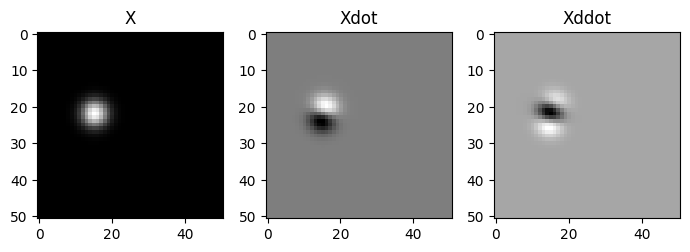

In [6]:
simul = 25
tstep = 123
fig = plt.figure(figsize=(7,7))
plt.subplot(1,3,1)
plt.imshow(X[simul,tstep],cmap='grey')
plt.title('X')
plt.subplot(1,3,2)
plt.imshow(Xdot[simul,tstep],cmap='grey')
plt.title('Xdot')
plt.subplot(1,3,3)
plt.imshow(Xddot[simul,tstep],cmap='grey')
plt.title('Xddot')
plt.tight_layout()

In [7]:
# Create reshaped tensors
X_train = torch.tensor(X.reshape((X.shape[0]*X.shape[1],X.shape[2]*X.shape[3]))).to(device)
Xdot_train = torch.tensor(Xdot.reshape((Xdot.shape[0]*Xdot.shape[1],Xdot.shape[2]*Xdot.shape[3]))).to(device)
Xddot_train = torch.tensor(Xddot.reshape((Xddot.shape[0]*Xddot.shape[1],Xddot.shape[2]*Xddot.shape[3]))).to(device)
X_train.shape, Xdot_train.shape, Xddot_train.shape

(torch.Size([30500, 2601]),
 torch.Size([30500, 2601]),
 torch.Size([30500, 2601]))

In [8]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Create datasets
train_dataset, test_dataset = random_split(TensorDataset(X_train, Xdot_train, Xddot_train), [0.8, 0.2],
                                          generator=torch.Generator().manual_seed(123))

In [9]:
# Create dataloaders
batch_size_train = 64
batch_size_test = 500

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

In [10]:
xn_val = 0
xdn_val = 0
for (b_x, b_xdot, b_xddot) in train_dataset:
    xn_val += torch.linalg.vector_norm(b_x)
    xdn_val += torch.linalg.vector_norm(b_xdot)
l1_val = xn_val/xdn_val
l1_val

tensor(0.4890, device='cuda:0')

## Autoencoder network
![](autoencoder.png)

The autoencoder network is composed by two functions, an encoder function $\varphi$, and a decoder function $\psi$, so that
$$\mathbf{z}(t)=\varphi(\mathbf{x}(t)),$$
$$\hat{\mathbf{x}}(t)=\psi(\mathbf{z}(t)).$$

There are $n$ samples of the input of dimension $m$, so that it can be stored in a matrix
$$\mathbf{X}=\left[\begin{array}{cccc}x_1(t_1)&x_2(t_1)&\cdots&x_m(t_1)\\x_1(t_2)&x_2(t_2)&\cdots&x_m(t_2)\\\vdots&\vdots&\ddots&\vdots\\x_1(t_n)&x_2(t_n)&\cdots&x_m(t_n)\\\end{array}\right]=\left[\begin{array}{c}\mathbf{x}(t_1)\\\mathbf{x}(t_2)\\\vdots\\\mathbf{x}(t_n)\end{array}\right].$$

It is important to note that here $t_i$ identifies the sample, not the time at which it was taken, and thus it does not folow a chronological order. The time enters into the problem by the relation of $\mathbf{X}$ and its time derivatives.  

In the same way, the latent space of dimension $k$ can be cast into a matrix form
$$\mathbf{Z}=\left[\begin{array}{cccc}z_1(t_1)&z_2(t_1)&\cdots&z_k(t_1)\\z_1(t_2)&z_2(t_2)&\cdots&z_k(t_2)\\\vdots&\vdots&\ddots&\vdots\\z_1(t_n)&z_2(t_n)&\cdots&z_k(t_n)\\\end{array}\right]=\left[\begin{array}{c}\mathbf{z}(t_1)\\\mathbf{z}(t_2)\\\vdots\\\mathbf{z}(t_n)\end{array}\right].$$

## SINDy

While the autoencoder is concerned with the dimensionality reduction from the input to the latent space, the model (diferential equation) in that latent space is fitted by means of the SINDy (sparse identification of nonlinear dynamics) algorithm. 2nd order SINDy assumes that the dynamics for the latent space variables is described by
$$\ddot{\mathbf{z}}(t)=\epsilon_0+\sum_{i=1}^N\epsilon_if_i(\mathbf{z},\dot{\mathbf{z}};t),$$

where the $f_i$ are a set of $N$ base functions of $\mathbf{z}$ and $\dot{\mathbf{z}}$ called the SINDy library, and $\epsilon_i=[\varepsilon_{i,1},\varepsilon_{i,2},\cdots,\varepsilon_{i,k}]$, $0\leq i\leq N$, are the weights associated with each function $f_i$ for each of the variables $z_j$. The idea behind SINDy is that most of the $\varepsilon_{i,j}$ weights will tend to zero during the training of the model, so as to produce a sparse model. The resulting system of differential equations can be cast in a matrix form as
$$\ddot{\mathbf{Z}}=\left[\begin{array}{cccc}1&f_1(t_1)&\cdots&f_N(t_1)\\1&f_1(t_2)&\cdots&f_N(t_2)\\\vdots&\vdots&\ddots&\vdots\\1&f_1(t_n)&\cdots&f_N(t_n)\end{array}\right]\left[\begin{array}{cccc}\varepsilon_{01}&\varepsilon_{02}&\cdots&\varepsilon_{0k}\\\varepsilon_{11}&\varepsilon_{12}&\cdots&\varepsilon_{1k}\\\vdots&\vdots&\ddots&\vdots\\\varepsilon_{N1}&\varepsilon_{N2}&\cdots&\varepsilon_{Nk}\end{array}\right]=\Theta(\mathbf{Z},\dot{\mathbf{Z}})\ \Xi.$$

#### Example
For example, say we decide for the latent space to be of dimension $k=2$, and we create a SINDy library composed by the functions $f_1(\mathbf{z},\dot{\mathbf{z}})=z_1$, $f_2(\mathbf{z},\dot{\mathbf{z}})=z_2$, $f_3(\mathbf{z},\dot{\mathbf{z}})=\dot{z}_1$, $f_4(\mathbf{z},\dot{\mathbf{z}})=\dot{z}_2$, $f_5(\mathbf{z},\dot{\mathbf{z}})=z_1^2$, $f_6(\mathbf{z},\dot{\mathbf{z}})=z_2^2$, and $f_7(\mathbf{z},\dot{\mathbf{z}})=z_1z_2$. Imagine that by the end of the training process the coefficients take the values

$$\left[\begin{array}{cc}\varepsilon_{01}&\varepsilon_{02}\\\varepsilon_{11}&\varepsilon_{12}\\\varepsilon_{21}&\varepsilon_{22}\\\varepsilon_{31}&\varepsilon_{32}\\\varepsilon_{41}&\varepsilon_{42}\\\varepsilon_{51}&\varepsilon_{52}\\\varepsilon_{61}&\varepsilon_{62}\\\varepsilon_{71}&\varepsilon_{72}\end{array}\right]=\left[\begin{array}{cc}0&1\\1&0\\0&0\\0&1\\0&0\\1&0\\0&1\\0&1\end{array}\right],$$
then the resulting dynamic equations would be
$$\ddot{z}_1=z_1+z_1^2,$$
$$\ddot{z}_2=1+\dot{z}_1+z_2^2+z_1z_2.$$

## Training

Training the model is a regression process thet requires de defintion of a loss function which has to be minimized. The loss function for the SINDy autoencoder is composed of four terms. The first term, reconstruction loss, is the typical mean square function for an autoencoder:
$$J_0=\|\mathbf{x}-\hat{\mathbf{x}}\|_2^2.$$
The second term enforces the convergence of the second derivative for the input
$$J_1=\|\ddot{\mathbf{x}}-\ddot{\hat{\mathbf{x}}}\|_2^2.$$
The third term enforces the dynamical equation for the latent space
$$J_2=\|\ddot{\mathbf{z}}-\Theta(\mathbf{z},\dot{\mathbf{z}})\Xi\|_2^2.$$
And the last term is a regularization that promtes sparsity for the SINDy coefficients
$$J_3=\|\Xi\|_1.$$
The total loss function is then
$$J=J_0+\lambda_1J_1+\lambda_2J_2+\lambda_3J_3,$$
where the $\lambda_i$ are hyperparameters of the trainig process.

Let $\mathbf{W}_i$ be the weight matrices of the layers in the network, and $\mathbf{b}_i$ be the bias. We compute the function $$\varphi(\mathbf{x})=\mathbf{W}_{L-1}\mathbf{a}_{L-1}+\mathbf{b}_{L-1},$$
where $L$ is the number of layers of the encoder/decoder,
$$\mathbf{a}_i=h(\zeta_{i-1}),\ \zeta_{i}=\mathbf{W}_{i}\mathbf{a}_i+\mathbf{b}_i,$$
and $h(\zeta)$ is the activation function. To compute $\varphi$ we iterate over the layers of the network and obtain all $\mathbf{a}_i$'s we iterate over the layers
$$\mathbf{a}_1=h(\mathbf{W}_{0}\mathbf{x}+\mathbf{b}_0)$$
$$\vdots$$
$$\mathbf{a}_i=h(\mathbf{W}_{i-1}\mathbf{a}_{i-1}+\mathbf{b}_{i-1})$$
$$\vdots$$
$$\varphi(\mathbf{x})=\mathbf{W}_{L-1}\mathbf{a}_{L-1}+\mathbf{b}_{L-1}.$$

In order to minimize the loss function the gradient descent algorithm is used. This requires for us to obtain the gradient of the loss function with respect to all of the coefficients, including the network weights and SINDy coefficients.\
t\ddot{\mathbf{x}}$$

In addition, to obtain the time derivatives $\ddot{\hat{\mathbf{x}}}$ and $\ddot{\mathbf{z}}$, which are required to compute the loss function, we will need to compute gradients with respect to these variables, as the time derivative of $\varphi$ is
$$\frac{d\varphi}{dt}(\mathbf{x})=\nabla_{\mathbf{x}}\varphi(\mathbf{x})\cdot\dot{\mathbf{x}}=\mathbf{W}_{L-1}\frac{d\mathbf{a}_{L-1}}{dt}$$
which, in the case where $h$ is the sigmoid function, is calculated as
$$\dot{\mathbf{a}}_1=\mathbf{a}_1(1-\mathbf{a}_1)\mathbf{W}_0\dot{\mathbf{x}}$$
$$\vdots$$
$$\dot{\mathbf{a}}_i=\mathbf{a}_i(1-\mathbf{a}_i)\mathbf{W}_{i-1}\dot{\mathbf{a}}_{i-1}$$
$$\vdots$$
$$\frac{d\varphi}{dt}=\mathbf{W}_{L-1}\dot{\mathbf{a}}_{L-1}.$$

The 2nd time derivative is
$$\frac{d^2\varphi}{dt^2}(\mathbf{x})=\nabla_{\mathbf{x}}\left(\nabla_{\mathbf{x}}\varphi(\mathbf{x})\cdot\dot{\mathbf{x}}\right)\cdot\dot{\mathbf{x}}+\nabla_{\mathbf{x}}\varphi(\mathbf{x})\cdot\ddot{\mathbf{x}}=\mathbf{W}_{L-1}\frac{d\dot{\mathbf{a}}_{L-1}}{dt},$$
which in the case $h$ is the logistic function, is calculated as
$$\ddot{\mathbf{a}}_1=(2\mathbf{a}_1^3-3\mathbf{a}_1^2+\mathbf{a}_1)\mathbf{W}_0\dot{\mathbf{x}}\mathbf{W}_0\dot{\mathbf{x}}+\mathbf{a}_1(1-\mathbf{a}_1)\mathbf{W}_0\ddot{\mathbf{x}}$$
$$\vdots$$
$$\ddot{\mathbf{a}}_i=(2\mathbf{a}_i^3-3\mathbf{a}_i^2+\mathbf{a}_i)\mathbf{W}_{i-1}\dot{\mathbf{a}}_{i-1}\mathbf{W}_{i-1}\dot{\mathbf{a}}_{i-1}+\mathbf{a}_i(1-\mathbf{a}_i)\mathbf{W}_{i-1}\ddot{\mathbf{a}}_{i-1}$$
$$\vdots$$
$$\frac{d^2\varphi}{dt^2}=\mathbf{W}_{L-1}\ddot{\mathbf{a}}_{L-1}.$$

The case of the decoder function $\psi(\mathbf{z})$ is similar, save for the last layer, which applies the sigmoid function. Therefore
$$\psi(\mathbf{z})=h(\mathbf{W}_{L-1}\mathbf{a}_{L-1}+\mathbf{b}_{L-1}),$$
$$\frac{d\psi}{dt}=\dot{\mathbf{a}}_{L-1}(1-\dot{\mathbf{a}}_{L-1})\mathbf{W}_{L-2}\dot{\mathbf{a}}_{L-2},$$
$$\frac{d^2\psi}{dt^2}=(2\mathbf{a}_{L-1}^3-3\mathbf{a}_{L-1}^2+\mathbf{a}_{L-1})\mathbf{W}_{L-2}\dot{\mathbf{a}}_{L-2}\mathbf{W}_{L-2}\dot{\mathbf{a}}_{L-2}+\mathbf{a}_{L-1}(1-\mathbf{a}_{L-1})\mathbf{W}_{L-2}\ddot{\mathbf{a}}_{L-2}.$$

The dimension of the latent space will be chosen as 1, because the simple pendulum has a single degree of freedom. In a general case where this is not known a priory, the authors of the original paper suggest first training a standard autoencoder without the associated SINDy model to determine the minimum number of coordinates necessary to reproduce the input data.

The SINDy library will be composed of the following functions: $1$, $\mathbf{z}$, $\mathbf{z}^2$, $\mathbf{z}^3$, $\sin(\mathbf{z})$, $\cos(\mathbf{z})$, $\dot{\mathbf{z}}$, $\dot{\mathbf{z}}^2$, $\dot{\mathbf{z}}^3$, and $\mathbf{z}\dot{\mathbf{z}}$. 

Encoder:\
2601 => 1200 => 600 => 200 => 80 => 10 => 1  

Decoder:\
1 => 10 => 80 => 200 => 600 => 1200 => 2601

In [11]:
class SindyAutoEncoder(nn.Module):
    def __init__(self, layer_sizes=[2601,1200,600,200,80,10,1]):
        super().__init__()

        # Layers for the encoder
        self.encoder_layers = nn.ModuleList()
        for i in range(len(layer_sizes)-1):
            self.encoder_layers.append(nn.Linear(layer_sizes[i],layer_sizes[i+1]))

        # Layers for the decoder
        self.decoder_layers = nn.ModuleList()
        for i in range(len(layer_sizes)-1,0,-1):
            self.decoder_layers.append(nn.Linear(layer_sizes[i],layer_sizes[i-1]))

        # Layer that computes the SINDY approximation of the second derivative.
        # The weights are the sindy coefficients for the 10 functions in the library.
        # (NOTE: Should the bias in nn.Linear count as the constant term?)
        self.sindy = nn.Linear(10,layer_sizes[-1]) 

        self.initialize_weights()

    # Initialize weights
    def initialize_weights(self):
        for m in self.modules():
            #print(m)
            if isinstance(m, nn.Linear):
                if m==self.sindy:
                    nn.init.constant_(m.weight, 1.0)
                else:
                    #nn.init.xavier_normal_(m.weight) #sigmoid
                    nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='sigmoid')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

    # Encode with linear layers and sigmoid activation functions
    #except the last one
    def encode(self, x):
        for layer in self.encoder_layers[:-1]:
            x = torch.sigmoid(layer(x))
        x = self.encoder_layers[-1](x)
        return x

    # Decode with linear layers and sigmoid activation functions
    #including the last one
    def decode(self, x):
        for layer in self.decoder_layers:
            x = torch.sigmoid(layer(x))
        return x

    # Forward pass through the network
    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat

    # Compute the approximation to the second derivative of the latent space (z) 
    # (2nd order dif. eq.), as a function of z and zdot. Assumes the latent dimension = 1
    def sindy_library(self, z, zdot):
        theta_ddot_lib = []
        for i in range(z.shape[0]):
            ddot = torch.stack([torch.ones(z[i].shape).to(device),
                                (z[i]).to(device),
                                (z[i]*z[i]).to(device),
                                (z[i]*z[i]*z[i]).to(device),
                                (torch.sin(z[i])).to(device),
                                (torch.cos(z[i])).to(device),
                                (zdot[i]).to(device),
                                (zdot[i]*zdot[i]).to(device),
                                (zdot[i]*zdot[i]*zdot[i]).to(device),
                                (z[i]*zdot[i]).to(device)
                               ])
            theta_ddot_lib.append(torch.flatten(ddot))
        return torch.stack(theta_ddot_lib)

    # Compute the time derivatives for the encoder
    def tderiv_encoder(self, x, xdot, xddot):
        # Obtain the weights (We) of the encoder layers
        weights = []
        for layer in self.encoder_layers:
            weights.append(layer.weight)

        # Obtain the ai's
        a = [torch.sigmoid(self.encoder_layers[0](x))]
        for i in range(1,len(self.encoder_layers)-1):
            a.append(torch.sigmoid(self.encoder_layers[i](a[-1])))
        a.append(self.encoder_layers[-1](a[-1]))
        
        # Obtain the time derivative of the ai's
        adot = [a[0]*(1-a[0])*torch.mm(weights[0],xdot.t()).t()]
        for i in range(1,len(self.encoder_layers)-1):
            adot.append(a[i]*(1-a[i])*torch.mm(weights[i],adot[-1].t()).t())
        adot.append(torch.mm(weights[-1],adot[-1].t()).t())
        
        # Obtain the 2nd time derivative of the ai's
        addot = [(2*a[0]**3-3*a[0]**2+a[0])*(torch.mm(weights[0],xdot.t()).t())**2+a[0]*(1-a[0])*torch.mm(weights[0],xddot.t()).t()]
        for i in range(1,len(self.encoder_layers)-1):
            addot.append((2*a[i]**3-3*a[i]**2+a[i])*(torch.mm(weights[i],adot[i-1].t()).t())**2+a[i]*(1-a[i])*torch.mm(weights[i],addot[-1].t()).t())
        addot.append(torch.mm(weights[-1],addot[-1].t()).t())
        
        z = a[-1]
        zdot = adot[-1]
        zddot = addot[-1]
        return z, zdot, zddot

    # Compute the time derivatives for the decoder
    def tderiv_decoder(self, z, zdot, zddot):
        # Obtain the weights (Wd) of the decoder layers
        weights = []
        for layer in self.decoder_layers:
            weights.append(layer.weight)

        # Obtain the ai's
        a = [torch.sigmoid(self.decoder_layers[0](z))]
        for i in range(1,len(self.decoder_layers)):
            a.append(torch.sigmoid(self.decoder_layers[i](a[-1])))
        
        # Obtain the time derivative of the ai's
        adot = [a[0]*(1-a[0])*torch.mm(weights[0],zdot.t()).t()]
        for i in range(1,len(self.decoder_layers)):
            adot.append(a[i]*(1-a[i])*torch.mm(weights[i],adot[-1].t()).t())
        
        # Obtain the 2nd time derivative of the ai's
        addot = [(2*a[0]**3-3*a[0]**2+a[0])*(torch.mm(weights[0],zdot.t()).t())**2+a[0]*(1-a[0])*torch.mm(weights[0],zddot.t()).t()]
        for i in range(1,len(self.decoder_layers)):
            addot.append((2*a[i]**3-3*a[i]**2+a[i])*(torch.mm(weights[i],adot[i-1].t()).t())**2+a[i]*(1-a[i])*torch.mm(weights[i],addot[-1].t()).t())

        x = a[-1]
        xdot = adot[-1]
        xddot = addot[-1]
        return x, xdot, xddot

In [12]:
learn_rate = 1.e-4
epochs = 20
log_interval = 20

In [13]:
# Instantiate model
model = SindyAutoEncoder().to(device)

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learn_rate,weight_decay=1e-8)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
sindy_weights = []

In [14]:
# Model trainer
def train(epoch, loss0, loss1, loss2, lambda1, lambda2, lambda3):
    model.train()
    for batch_idx, (batch_x, batch_xdot, batch_xddot) in enumerate(train_loader):
        #Forward pass through the network
        x_hat = model(batch_x)
        
        #Reconstruction loss (J_0)
        J0 = loss0(x_hat, batch_x)

        #Zddot loss (J_2)
        z, zdot, zddot = model.tderiv_encoder(batch_x, batch_xdot, batch_xddot)
        sindy_lib = model.sindy_library(z, zdot) 
        zddot_hat = model.sindy(sindy_lib)
        J2 = loss2(zddot_hat, zddot)

        #Regularization loss (J_3)
        J3 = torch.sum(torch.abs(model.sindy.weight))

        #Xddot loss (J_1)
        x, xdot, xddot = model.tderiv_decoder(z, zdot, zddot)
        J1 = loss1(xddot, batch_xddot)

        #Total loss
        loss = J0 + lambda1*J1 + lambda2*J2 + lambda3*J3
        
        #Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx%log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx*len(batch_x), len(train_loader.dataset),
                100.*batch_idx/len(train_loader), loss.item()
            ))
            train_losses.append(loss.item())
            train_counter.append(batch_idx*batch_size_train + epoch*len(train_loader.dataset))
            #Keep track of sundy weights
            sindy_weights.append(model.sindy.weight.cpu().detach().numpy())

# Model evaluation
def test(loss0, loss1, loss2, lambda1, lambda2, lambda3):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_xdot, batch_xddot in test_loader:
            x_hat = model(batch_x)
            J0 = loss0(x_hat, batch_x)
            
            z, zdot, zddot = model.tderiv_encoder(batch_x, batch_xdot, batch_xddot)
            sindy_lib = model.sindy_library(z, zdot) 
            zddot_hat = model.sindy(sindy_lib)
            J2 = loss2(zddot_hat, zddot)
            
            J3 = torch.sum(torch.abs(model.sindy.weight))
            
            x, xdot, xddot = model.tderiv_decoder(z, zdot, zddot)
            J1 = loss1(xddot, batch_xddot)
            
            loss = J0 + lambda1*J1 + lambda2*J2 + lambda3*J3
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss,))  

To choose hyperparameter $\lambda_1$, the authors suggest to use $\sum_i^m\|x_i\|_2^2/\sum_i^m\|\dot{x}_i\|_2^2$. They suggest $\lambda_2$ to be two orders of magnitude less than $\lambda_1$. $\lambda_3$ should be shosen to acheive the desired level of sparsity in the SINDy coefficients.

In [15]:
loss0 = nn.MSELoss()
loss1 = nn.MSELoss()
loss2 = nn.MSELoss()
lambda1 = l1_val
lambda2 = lambda1/100
lambda3 = 1.e-3

In [16]:
test(loss0, loss1, loss2, lambda1, lambda2, lambda3)
for epoch in range(epochs):
    train(epoch, loss0, loss1, loss2, lambda1, lambda2, lambda3)
    test(loss0, loss1, loss2, lambda1, lambda2, lambda3)

/home/carlos/python/environments/pytorchenv/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)



Test set: Avg. loss: 1.1272
Train Epoch: 0 [0/24400 (0%)]	Loss: 1.253377
Train Epoch: 0 [1280/24400 (5%)]	Loss: 1.074742
Train Epoch: 0 [2560/24400 (10%)]	Loss: 1.089319
Train Epoch: 0 [3840/24400 (16%)]	Loss: 0.830403
Train Epoch: 0 [5120/24400 (21%)]	Loss: 0.870575
Train Epoch: 0 [6400/24400 (26%)]	Loss: 0.793117
Train Epoch: 0 [7680/24400 (31%)]	Loss: 0.740919
Train Epoch: 0 [8960/24400 (37%)]	Loss: 0.699261
Train Epoch: 0 [10240/24400 (42%)]	Loss: 0.790702
Train Epoch: 0 [11520/24400 (47%)]	Loss: 0.779572
Train Epoch: 0 [12800/24400 (52%)]	Loss: 0.840807
Train Epoch: 0 [14080/24400 (58%)]	Loss: 0.773911
Train Epoch: 0 [15360/24400 (63%)]	Loss: 0.897048
Train Epoch: 0 [16640/24400 (68%)]	Loss: 0.709149
Train Epoch: 0 [17920/24400 (73%)]	Loss: 1.058013
Train Epoch: 0 [19200/24400 (79%)]	Loss: 0.919326
Train Epoch: 0 [20480/24400 (84%)]	Loss: 1.055872
Train Epoch: 0 [21760/24400 (89%)]	Loss: 1.303694
Train Epoch: 0 [23040/24400 (94%)]	Loss: 0.931486
Train Epoch: 0 [24320/24400 (99%)]

Text(0, 0.5, 'Loss')

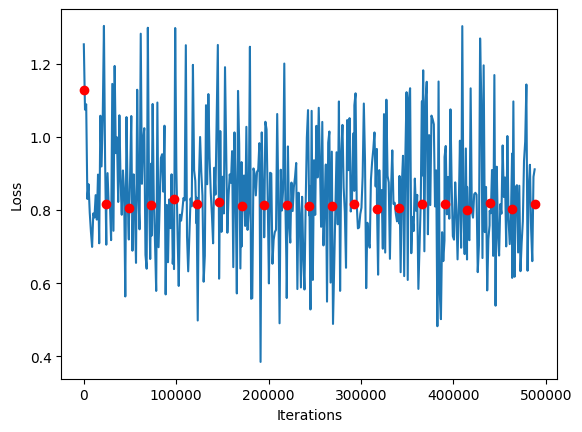

In [17]:
plt.plot(train_counter,train_losses,zorder=5)
plt.scatter(test_counter,test_losses,color='r',zorder=15)
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [18]:
sindy_w = np.transpose(np.array(sindy_weights).reshape(400,10))
sindy_w.shape

(10, 400)

Text(0, 0.5, 'sindy_weight')

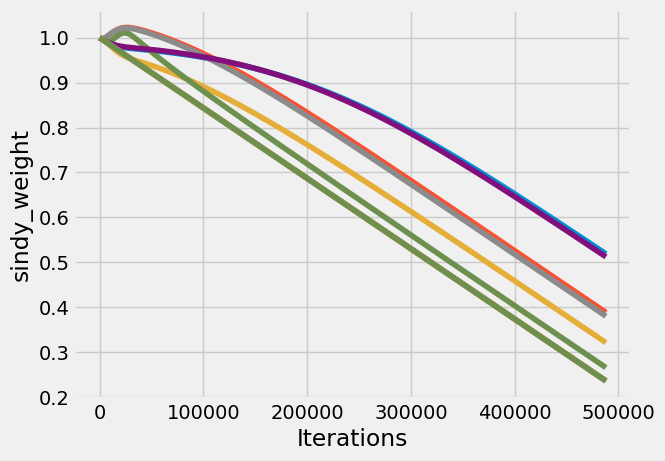

In [19]:
for i in range(10):
    plt.plot(train_counter,sindy_w[i])
plt.xlabel('Iterations')
plt.ylabel('sindy_weight')